In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import SGD, Adam
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [8]:
device = torch.device("cpu")

In [9]:
def sample_data():
    with open('mnist-hw1.pkl', 'rb') as file:
        dataset = pickle.load(file)

    X_train = dataset['train']
    X_test = dataset['test']
    return X_train, X_test

In [98]:
def plot_loss(loss_train, loss_val):
    plt.plot(np.arange(len(loss_train)), loss_train, label='train')
    plt.plot(np.arange(0, len(loss_train), len(loss_train) / N), loss_val, label='validate')
    plt.legend()
    plt.title("losses")
    plt.xlabel("step")
    plt.ylabel("loss")
    plt.show()

In [10]:
X_train, X_test = sample_data()
X_train, X_val = train_test_split(X_train, test_size=0.125, random_state=42)
X_train = X_train.transpose([0, 3, 1, 2])
X_val = X_val.transpose([0, 3, 1, 2])
X_test = X_test.transpose([0, 3, 1, 2])




In [15]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, padding=0, mask_type='B'):
        super().__init__(in_channels, out_channels, kernel_size, stride, padding)        
        self.mask = torch.ones_like(self.weight).to(device)
        _, _, h, w = self.weight.shape
        h, w = h // 2, w // 2
        
        self.mask[:, :, h, w + (mask_type == 'B'):] = 0
        self.mask[:, :, h + 1:] = 0
        
    def forward(self, input):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(input)


In [42]:
class MaskedResBlock(nn.Module):
    def __init__(self, size):
        super(MaskedResBlock, self).__init__()
        
        self.model = nn.Sequential(
            nn.ReLU(),
            MaskedConv2d(2 * size, size),
            nn.BatchNorm2d(size),
            nn.ReLU(),
            MaskedConv2d(size, size, kernel_size=3, padding=1),
            nn.BatchNorm2d(size),
            nn.ReLU(),
            MaskedConv2d(size, 2 * size),
            nn.BatchNorm2d(2 * size)
        )

    def forward(self, x):
        return self.model(x) + x

In [49]:
class PixelCNN(nn.Module):
    def __init__(self, size):
        super(PixelCNN, self).__init__()

        arch = [MaskedConv2d(3, 2 * size, kernel_size=7, stride=1, padding=3, mask_type='A')]
        
        arch += 12 * [MaskedResBlock(size)]
        arch += [
            nn.ReLU(),
            MaskedConv2d(2 * size, 2 * size),
            nn.BatchNorm2d(2 * size),
            nn.ReLU(),
            MaskedConv2d(2 * size, 3 * 4)
        ]
                 
        self.model = nn.Sequential(*arch)

    def forward(self, x):
        return self.model(x.float()).reshape(x.shape[0], x.shape[1], 4, x.shape[2], x.shape[3]).permute(0, 1, 3, 4, 2)

In [74]:
def one_hot_v2(batch,depth):
    ones = torch.sparse.torch.eye(depth).to(device)
    return ones.index_select(0,batch)

In [75]:
def MyNLLLoss(x, y):
    y = torch.nn.functional.softmax(y, dim=4).to(device)
    
    x4 = x[:, :, :, :]
    one_hot = torch.zeros((x.shape[0], x.shape[1], x.shape[2], x.shape[3], 4)).float().to(device)
    one_hot[:, :, :, :] = one_hot_v2(x4.view(-1).long(),4).view(one_hot.shape)
    return -torch.log((y * one_hot).sum(dim=-1)).mean()

In [92]:
model = PixelCNN(8)
model = model.float()
model = model.to(device)

optimizer = SGD(model.parameters(), lr=1e-3, momentum=0.9)
loss = MyNLLLoss
N = 10
Nb = 64

In [93]:
train_loader = DataLoader(X_train, batch_size=Nb, shuffle=True)
val_loader = DataLoader(X_val, batch_size=len(X_val))
test_loader = DataLoader(X_test, batch_size=len(X_test))

In [94]:
def train():
    loss_train, loss_val = [], []
            
    for _ in range(N):
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            loss_ = loss(batch, model(batch))
            loss_train.append(loss_ / 2)
            loss_.backward()
            optimizer.step()

        with torch.no_grad():
            for batch_data in val_loader:
                batch = batch.to(device)
                loss_ = loss(batch, model(batch))
                loss_val.append(loss_ / 2)

    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            loss_ = loss(batch, model(batch))
            print("Test loss: " + str(float(loss_ / 2)))

    return loss_train, loss_val



In [95]:
loss_train, loss_val = train()


Test loss: 0.13655439019203186


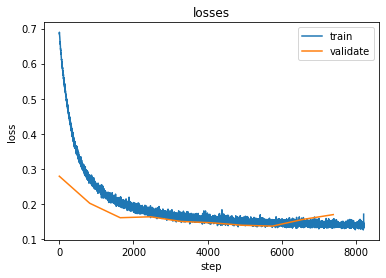

In [99]:
plot_loss(loss_train, loss_val)

In [ ]:
#слишком медленно